## 整理資料

In [1]:
import numpy as np
data=[]
with open('BikeSharingData/day.csv','r') as f:
    f.readline () # skip first row
    for line in f:
        columns = line.strip (). split (',')
        # from season to cnt
        data.append ( columns [2:])
    
data_mat = np.asarray (data , dtype=np. float32 )
print(data_mat.shape)

(731, 14)


### 讀取，保存

In [2]:
np.save('BikeSharingData/day.npy', data_mat)
data_restore = np.load('BikeSharingData/day.npy')
print ( data_restore . shape )
print ( data_restore [0,:])
#print ( data_restore [:,-1])

(731, 14)
[  1.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   6.00000000e+00   0.00000000e+00   2.00000000e+00   3.44166994e-01
   3.63624990e-01   8.05832982e-01   1.60446003e-01   3.31000000e+02
   6.54000000e+02   9.85000000e+02]


### 劃分訓練/測試集

In [3]:
# only train set and test set
tr = data_restore[0:-100 ,:]
ts = data_restore[-100:,:]
print (tr.shape)
print (ts.shape)

(631, 14)
(100, 14)


### 資料正規化

In [4]:
mean = np.mean(tr , axis=0)
stdv = np.std(tr , axis=0)
tr = (tr - mean) / stdv
ts = (ts - mean) / stdv
print (tr[0,:]) # 第一筆

[-1.28823662 -0.8536787  -1.51293707 -0.16639513  1.49614835 -1.4788053
  1.14527106 -0.88649201 -0.7392835   1.24404705 -0.41143009 -0.75909895
 -1.91749656 -1.7839427 ]


In [5]:
### 準備輸入輸出
x_train , y_train = tr[:, 0:11], tr[:, -1:]
x_test , y_test = ts[:,0:11 ,], ts[:, -1:]
print ( x_train.shape, y_train.shape )

(631, 11) (631, 1)


## 設計模型架構

In [6]:
import tensorflow as tf
feat_dim, hid_dim , out_dim = x_train.shape[1], 16 , 1
W_1 = tf. Variable (tf. random_normal ([feat_dim , hid_dim ], stddev =1.0), name="W_1")
b_1 = tf. Variable (tf. zeros ([ hid_dim ]), name="b_1")
W_2 = tf. Variable (tf. random_normal ([hid_dim , hid_dim ], stddev =1.0), name="W_2")
b_2 = tf. Variable (tf. zeros ([ hid_dim ]), name="b_2")
W_o = tf. Variable (tf. random_normal ([hid_dim , out_dim ], stddev =1.0), name="W_o")
x = tf. placeholder (dtype=tf.float32 , shape =(None ,feat_dim ), name="x")
h1 = tf. sigmoid (tf. matmul (x, W_1)+b_1)
h2 = tf. sigmoid (tf. matmul (h1 , W_2)+b_2)
y = tf. matmul (h2 , W_o , name='output')

## 減損函數

In [7]:
y_true = tf.placeholder ( dtype=tf.float32, shape =(None , 1))
loss = tf.reduce_mean ((0.5)*tf.pow(y-y_true , 2))
# Check y and y_true
print (y.shape , y_true . shape )

(?, 1) (?, 1)


## 模型訓練，參數搜尋
### 定義學習步伐

In [8]:
batch_size , n_samples = 8, x_train.shape[0]
decay_steps = n_samples / batch_size
global_step = tf.Variable(0, trainable = False )
learning_rate = tf.train.exponential_decay(0.1, global_step, decay_steps, decay_rate =0.5)

### SGD+Momentum

In [9]:
optimizer = tf.train . MomentumOptimizer(learning_rate, momentum =0.9)
train_step = optimizer.minimize(loss, global_step)
#train_step = tf.train.AdamOptimizer().minimize(loss)

### Session

In [10]:
saver = tf.train.Saver()
sess_config = tf.ConfigProto(
    allow_soft_placement = True,
    log_device_placement = True)
with tf.Session ( config = sess_config ) as sess:
    sess.run(tf.global_variables_initializer())
    idx = np.arange( n_samples ) # 0, 1, 2 ,... n_sample -1
    np.random.shuffle (idx)
    for epoch in range (1,16): # 1 ~ 15
        for beg in range (0, n_samples , batch_size):
            x_batch = x_train[idx[beg:beg+ batch_size],]
            y_batch = y_train[idx[beg:beg+ batch_size],]
            sess.run(train_step, feed_dict ={x: x_batch , y_true : y_batch })
        tr_loss = sess.run(loss , feed_dict ={x: x_train , y_true : y_train })
        ts_loss = sess.run(loss , feed_dict ={x: x_test , y_true : y_test })
        print ("epoch %02d: tr_loss =%f, ts_loss =%f" % (epoch , tr_loss , ts_loss ))
        saver .save(sess , "Model/bike.epoch_%02d" % (epoch ))

epoch 01: tr_loss =0.175803, ts_loss =0.313513
epoch 02: tr_loss =0.092853, ts_loss =0.200503
epoch 03: tr_loss =0.080718, ts_loss =0.190369
epoch 04: tr_loss =0.077670, ts_loss =0.190243
epoch 05: tr_loss =0.076431, ts_loss =0.190438
epoch 06: tr_loss =0.075913, ts_loss =0.190448
epoch 07: tr_loss =0.075666, ts_loss =0.190440
epoch 08: tr_loss =0.075544, ts_loss =0.190433
epoch 09: tr_loss =0.075484, ts_loss =0.190429
epoch 10: tr_loss =0.075455, ts_loss =0.190427
epoch 11: tr_loss =0.075440, ts_loss =0.190426
epoch 12: tr_loss =0.075432, ts_loss =0.190425
epoch 13: tr_loss =0.075429, ts_loss =0.190425
epoch 14: tr_loss =0.075427, ts_loss =0.190425
epoch 15: tr_loss =0.075426, ts_loss =0.190425


## 觀察結果

In [11]:
with tf. Session () as sess:
    saver. restore (sess , "Model/bike.epoch_14")
    y_pred = sess.run(y, feed_dict ={x: x_test , y_true :y_test })
    
cnt_pred = y_pred * stdv[-1] + mean[-1]
cnt_true = y_test * stdv[-1] + mean[-1]

INFO:tensorflow:Restoring parameters from Model/bike.epoch_14


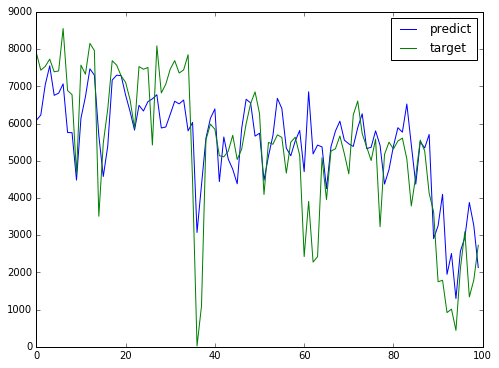

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8,6]
day = range(100)
plt.plot(day , cnt_pred , label='predict')
plt.hold(True)
plt.plot(day , cnt_true , label='target')
plt.legend()
plt.savefig('BikeSharing.png')
plt.show()